In [1]:
%matplotlib inline

In [2]:
### Import Packages

import matplotlib.pyplot as plt
import numpy as np
import starry
import pandas as pd
from glob import glob
import os
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import theano
import theano.tensor as tt
import theano.sparse as ts
from scipy.io import readsav
import imageio

In [3]:
### Starry configuration
np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

In [4]:
# read in data
M0030_1450 = readsav('2M0030-1450_calibch1_bin5_ap_opt.sav')
time_M0030_1450 = np.array(M0030_1450['bint'][:,0],dtype='float64')
flux_M0030_1450 = np.array(M0030_1450['binflux'][:,0],dtype='float64')
peakp_M0030_1450 = np.array(M0030_1450['peakp'],dtype='float64')
name_M0030_1450=M0030_1450['targ_name'].decode('utf-8')
# calculate error
fluxerr_M0030_1450 = np.zeros_like(flux_M0030_1450) + np.std(flux_M0030_1450 - np.roll(flux_M0030_1450, 1))/np.sqrt(2)

NameError: name 'flux_M0030_1450' is not defined

In [5]:
## now the fun part! 
## instantiate a map so we can do inference on this dataset
map = starry.Map(ydeg=5, reflected=False)
map.obl = 0
map.inc = 90

In [6]:
## set the data vector (the flux and the covariance matrix)
map.set_data(flux_M0030_1450, C=fluxerr_M0030_1450**2)

In [7]:
### Map variables

mu = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
mu[0] = 1 # sets the first entry of mu to 0
mu[1:] = 0 # Sets the rest of the entries in mu to 1
L = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
L[0] = 1e0 # sets the first entry of L to 1e0
L[1:] = 1e-5 # sets the rest of the entries in L to 1e-5
map.set_prior(L=L) #set the prior mean and covariance of the spherical harmonic coefficients

In [8]:
### More map variables

nrot=max(time_M0030_1450)/4.22 # Calculate the number of rotations
npts = len(time_M0030_1450) # create an array with the same number of data points as time_r5_degree
theta = np.linspace(0, 360 * nrot, npts) # returns an array that's evenly spaced between 0 and 360(nrot) spaced by npts
# Rotate to an observer inclination
map.inc=90


# Position of the star relative to the planet in the orbital plane
t = np.reshape(time_M0030_1450, (1, -1))
p = np.vstack((np.cos(2 * np.pi * t), np.sin(2 * np.pi * t), 0 * t))

ci = np.cos(map.inc * np.pi / 180)
si = np.sin(map.inc * np.pi / 180)
R = np.array([[1, 0, 0], [0, ci, -si], [0, si, ci]])
xs, ys, zs = R.dot(p)
kwargs = dict(theta=theta, xs=xs, ys=ys, zs=zs)

In [9]:
%%time
mu, cho_cov = map.solve(**kwargs)

CPU times: user 396 ms, sys: 126 ms, total: 522 ms
Wall time: 3.91 s


In [10]:
map.show(colorbar=True, projection="moll",file="2M0030-1450/M0030-1450_ydeg5.jpg")

/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/starry/_plotting.py:64: RuntimeWarning: invalid value encountered in true_divide
  2 + 2 * np.cos(2 * theta)


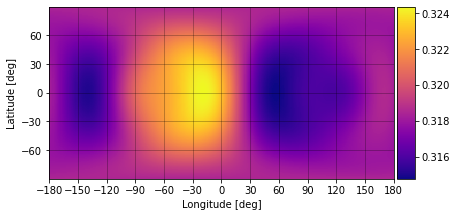

In [11]:
map.show(colorbar=True, projection="rect")

In [12]:
map.y

array([ 1.00000000e+00, -2.35990003e-19,  4.25122367e-03, -4.26545088e-03,
        2.14737230e-20, -2.55786829e-19,  1.84896497e-03, -4.33215259e-03,
       -1.06749883e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.71770886e-19,  8.87793100e-19,  2.91015251e-19, -7.76931585e-19,
        8.46763007e-04, -2.19809383e-04, -1.06552878e-03,  7.51545796e-04,
        3.76076518e-04, -2.83579076e-33, -1.59285926e-33,  1.89631633e-33,
        1.90214603e-33,  3.04250357e-33, -2.70382451e-18, -5.88586034e-18,
       -1.04869752e-17,  8.77242734e-18,  1.19129907e-17, -1.53614868e-18])

In [13]:
map.visualize()

AttributeError: 'Map' object has no attribute 'visualize'

In [ ]:
map.load(maps=flux_M0030_1450,image=)

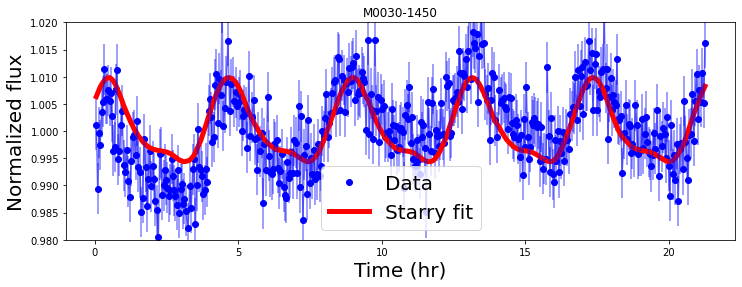

In [14]:
## Plotting
fig, ax = plt.subplots(1, figsize=(12, 4))
plt.title("M0030-1450")
plt.plot(time_M0030_1450, flux_M0030_1450,label="Data",linestyle="none",marker="o",color="blue")
plt.ylim(0.98,1.02)
plt.plot(time_M0030_1450, map.flux(**kwargs),label="Starry fit",linewidth=5,color="red")
plt.legend(prop={'size': 20})
plt.errorbar(time_M0030_1450, flux_M0030_1450, fluxerr_M0030_1450,alpha=0.5,color="blue")
ax.set_xlabel("Time (hr)", fontsize=20)
ax.set_ylabel("Normalized flux", fontsize=20)
plt.savefig("M0030_1450_LightCurve.jpg")

In [15]:
### Marginal Likelihood

amp_true = 0.9
inc_true = 90.0
period_true = 4.22
time = time_M0030_1450

def get_lnlike(inc):
    map.inc = inc
    theta = 360 / period_true * time
    return map.lnlike(theta=theta)

incs = np.linspace(0, 90, 50)
lnlike = np.array([get_lnlike(inc) for inc in incs])

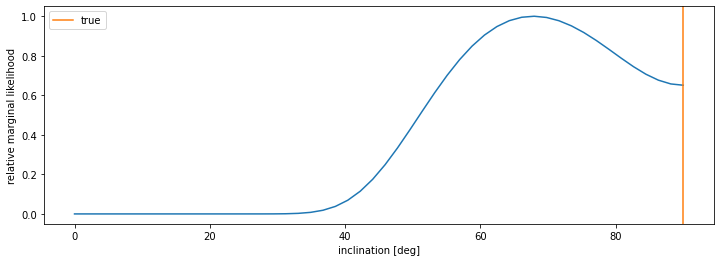

In [16]:
### Plotting Marginal Likelihood

fig, ax = plt.subplots(1, figsize=(12, 4))
like = np.exp(lnlike - lnlike.max())
plt.plot(incs, like)
plt.xlabel(r"inclination [deg]")
plt.ylabel(r"relative marginal likelihood")
plt.axvline(inc_true, color="C1", label="true")
plt.legend()

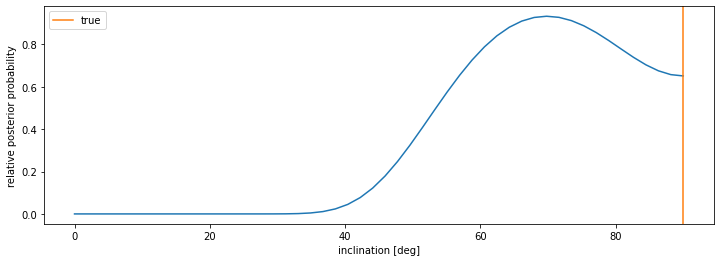

In [17]:
fig, ax = plt.subplots(1, figsize=(12, 4))
posterior = like * np.sin(incs * np.pi / 180)
plt.plot(incs, posterior)
plt.xlabel(r"inclination [deg]")
plt.ylabel(r"relative posterior probability")
plt.axvline(inc_true, color="C1", label="true")
plt.legend();

In [18]:
def get_lnlike(inc, period):
    map.inc = inc
    theta = 360 / period * time
    return map.lnlike(theta=theta)

In [19]:
%%time
incs = np.linspace(0, 90, 500)
periods = np.linspace(1, 5., 500)

lnlike = np.zeros((500, 500))
for i, inc in enumerate(incs):
    for j, period in enumerate(periods):
        lnlike[i, j] = get_lnlike(inc, period)

CPU times: user 24min 25s, sys: 2min, total: 26min 26s
Wall time: 12min 32s


In [20]:
like = np.exp(lnlike - lnlike.max())
posterior = like * np.sin(incs * np.pi / 180).reshape(-1, 1)

In [80]:
lnlike

array([[1340.26123899, 1340.26123899, 1340.26123899, ..., 1340.26123899,
        1340.26123899, 1340.26123899],
       [1340.26075601, 1340.25893725, 1340.25905824, ..., 1340.36730593,
        1340.36259275, 1340.35800314],
       [1340.25928543, 1340.25206385, 1340.2525444 , ..., 1340.68244155,
        1340.66372479, 1340.64549862],
       ...,
       [1335.00886028, 1333.17741893, 1334.71949682, ..., 1379.35424268,
        1377.65600555, 1376.00712985],
       [1335.00901291, 1333.17668914, 1334.71915673, ..., 1379.35428642,
        1377.65604371, 1376.00716262],
       [1335.0090638 , 1333.17644578, 1334.71904333, ..., 1379.354301  ,
        1377.65605642, 1376.00717353]])

In [78]:
posterior.max()

0.9628648169749914

In [75]:
like.max()

1.0

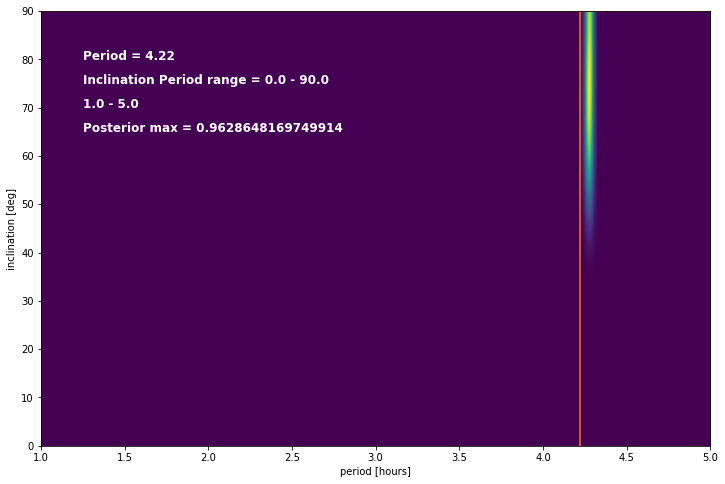

In [25]:
plt.figure(figsize=(12, 8))
plt.imshow(
    posterior,
    extent=(periods[0], periods[-1], incs[0], incs[-1]),
    origin="lower",
    aspect="auto",
)
plt.text(1.25,80,"Period = "+str(period_true),c="white",weight="heavy",size="large")
plt.text(1.25,75,"Inclination Period range = "+str(incs[0])+" - "+str(incs[-1]),c="white",weight="heavy",size="large")
plt.text(1.25,70,str(periods[0])+" - "+str(periods[-1]),c="white",weight="heavy",size="large")
plt.text(1.25,65,"Posterior max = " +str(posterior.max()),c="white",weight="heavy",size="large")
plt.axvline(period_true, color="C1")
plt.axhline(inc_true, color="C1")
plt.xlabel("period [hours]")
plt.ylabel("inclination [deg]");
plt.savefig("2M0030-1450_Likelihood.jpg")

In [21]:
### Split into individual rotations

time_M0030_1450_rot0 = time_M0030_1450[0:89]
flux_M0030_1450_rot0 = flux_M0030_1450[0:89]
fluxerr_M0030_1450_0 = fluxerr_M0030_1450[0:89]
fluxfitted_M0030_1450_rot0 = []

time_M0030_1450_rot1 = time_M0030_1450[90:173]
flux_M0030_1450_rot1 = flux_M0030_1450[90:173]
fluxerr_M0030_1450_1 = fluxerr_M0030_1450[90:173]
fluxfitted_M0030_1450_rot1 = []

time_M0030_1450_rot2 = time_M0030_1450[173:261]
flux_M0030_1450_rot2 = flux_M0030_1450[173:261]
fluxerr_M0030_1450_2 = fluxerr_M0030_1450[173:261]
fluxfitted_M0030_1450_rot2 = []

time_M0030_1450_rot3 = time_M0030_1450[261:348]
flux_M0030_1450_rot3 = flux_M0030_1450[261:348]
fluxerr_M0030_1450_3 = fluxerr_M0030_1450[261:348]
fluxfitted_M0030_1450_rot3 = []

time_M0030_1450_rot4 = time_M0030_1450[348:436]
flux_M0030_1450_rot4 = flux_M0030_1450[348:436]
fluxerr_M0030_1450_4 = fluxerr_M0030_1450[348:436]
fluxfitted_M0030_1450_rot4 = []

In [22]:
## Instantiate the map
map = starry.Map(ydeg=5, reflected=False)
map.obl = 0
map.inc = 90
map.set_data(flux_M0030_1450_rot0 ,C=fluxerr_M0030_1450_0**2)

## Other map parameters
mu = np.empty(map.Ny)
mu[0] = 1
mu[1:] = 0
L = np.empty(map.Ny)
L[0] = 1e0
L[1:] = 1e-5
map.set_prior(L=L)
nrot=1
npts = len(time_M0030_1450_rot4)
theta = np.linspace(0, 360 * nrot, npts)
kwargs = dict(theta=theta)
mu, cho_cov = map.solve(**kwargs)
map.show(colorbar=True,figsize=(10,10), projection="moll",dpi=500,file="2M0030-1450/Maps/2M0030_1450_map4.jpg")
    
## Saving fitted flux to a new array
fluxfitted_M0030_1450_rot4 = map.flux(**kwargs)
    
## Plotting
fig, ax = plt.subplots(1, figsize=(12, 4))
plt.title("2MASS0030-1450")
plt.plot(time_M0030_1450_rot4, flux_M0030_1450_rot4,label="Data",linestyle="none",marker="o",color="blue")
plt.ylim(0.98,1.02)
plt.plot(time_M0030_1450_rot4, map.flux(**kwargs),label="Starry fit",linewidth=5,color="red")
plt.legend(prop={'size': 20})
plt.errorbar(time_M0030_1450_rot4, flux_M0030_1450_rot4, fluxerr_M0030_1450_4,alpha=0.5,color="blue")
ax.set_xlabel("Time (hr)", fontsize=20)
ax.set_ylabel("Normalized flux", fontsize=20)
plt.savefig("2M0030-1450/LightCurves/2M0030_1450_curve4.jpg")

ValueError: Shape mismatch: x has 89 cols (and 89 rows) but y has 88 rows (and 36 cols)
Apply node that caused the error: Dot22(AllocDiag{offset=0, axis1=0, axis2=1}.0, <TensorType(float64, matrix)>)
Toposort index: 7
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(89, 89), (88, 36)]
Inputs strides: [(712, 8), (288, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Dot22(InplaceDimShuffle{1,0}.0, Dot22.0)]]

Backtrace when the node is created(use Theano flag traceback__limit=N to make it longer):
  File "/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2381, in run_cell_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-54>", line 2, in time
  File "/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/starry/maps.py", line 909, in solve
    X, self._flux, self._C.cholesky, self._mu, self._L.inverse
  File "/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/starry/_core/utils.py", line 126, in wrapper
    func(instance, *dummy_args),
  File "/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/starry/_core/math.py", line 233, in solve
    CInvX = tt.dot(tt.diag(1 / cho_C ** 2), X)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
### Merged array with all the fitted data

fluxfitted_M0030_1450 = []
fluxfitted_M0030_1450 = np.concatenate((fluxfitted_M0030_1450_rot0,fluxfitted_M0030_1450_rot1,fluxfitted_M0030_1450_rot2,fluxfitted_M0030_1450_rot3,fluxfitted_M0030_1450_rot4))

timefitted_M0030_1450 = []
timefitted_M0030_1450 = np.concatenate((time_M0030_1450_rot0,time_M0030_1450_rot1,time_M0030_1450_rot2,time_M0030_1450_rot3,time_M0030_1450_rot4))

fluxerr_M0030_1450 = []
fluxerr_M0030_1450 = np.concatenate((fluxerr_M0030_1450_0,fluxerr_M0030_1450_1,fluxerr_M0030_1450_2,fluxerr_M0030_1450_3,fluxerr_M0030_1450_4))

In [ ]:
## Plotting
fig, ax = plt.subplots(1, figsize=(12, 4))
plt.title("2MASS0030-1450")
plt.plot(timefitted_M0030_1450, flux_M0030_1450[0:435],label="Data",linestyle="none",marker="o",color="blue")
#plt.ylim(0.98,1.02)
plt.plot(timefitted_M0030_1450, fluxfitted_M0030_1450,label="Starry fit",linewidth=5,color="red")
plt.legend(prop={'size': 20})
plt.errorbar(timefitted_M0030_1450, flux_M0030_1450[0:435], fluxerr_M0030_1450,alpha=0.5,color="blue")
ax.set_xlabel("Time (hr)", fontsize=20)
ax.set_ylabel("Normalized flux", fontsize=20)
plt.savefig("2M0030-1450_StarryFitted_Curve_ydeg5.jpg")

In [ ]:
map.show(colorbar=True, projection="moll",file="2M0030-1450/Maps/2M0030-1450_StarryFitted_Map_ydeg5.jpg")